In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import scipy.ndimage as ndimage
import matplotlib.patches as patches
import cv2
import numpy as np
import pandas as pd
import os,gc
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
torch.cuda.set_device(7)
print (torch.cuda.current_device())
#os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3,4,5,6,7"

7


In [ ]:
def Image_Processing(img_path, crop_size=224):
    img = Image.open(img_path).convert('RGB').resize((256, 256),Image.ANTIALIAS) #open and resize
    #crop and normalize
    transform_sequence = transforms.Compose([
                                             #transforms.ToPILImage(), #if not PILImage
                                             transforms.CenterCrop(crop_size),
                                             #transforms.RandomCrop(crop_size),
                                             #transforms.RandomHorizontalFlip(),
                                             transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
                                             transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
    img = transform_sequence(img).numpy() #tensor to numpy
    return img
img_path = '/data/fjsdata/NIH-CXR/images/images/' 
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', \
               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
#preparing the trainset and  testset
trN, trI, trY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/train.txt', "r") as file_descriptor: #tarinset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            trN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            trY.append(np.array(image_label))
            img = Image_Processing(os.path.join(img_path, image_name))
            trI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(trN),78468))
        sys.stdout.flush()
trI = np.array(trI)
trY = np.array(trY)   
print('The length of trainset is %d'%len(trN))
        
valN, valI, valY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/val.txt', "r") as file_descriptor: #valset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            valN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            valY.append(np.array(image_label))
            img = Image_Processing(os.path.join(img_path, image_name))
            valI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(valN),11219))
        sys.stdout.flush()
valI = np.array(valI)
valY = np.array(valY) 
print('The length of validset is %d'%len(valN))

teN, teI, teY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/test.txt', "r") as file_descriptor: #testset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            teN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            teY.append(np.array(image_label))
            img = Image_Processing(os.path.join(img_path, image_name))                    
            teI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(teN),22433))
        sys.stdout.flush()
teI = np.array(teI)
teY = np.array(teY)    
print('The length of testset is %d'%len(teN))

#preparing bounding box dataset
boxdata = pd.read_csv("/data/fjsdata/NIH-CXR/chexnet_dataset/fjs_BBox.csv" , sep=',')
boxdata = boxdata[['Image Index','Finding Label','Bbox [x', 'y', 'w', 'h]']]
#print('Dataset statistic, records: %d, fields: %d' % (boxdata.shape[0], boxdata.shape[1]))
#print(boxdata.columns.values.tolist())
bbN, bbI, bbY, bBox = [],[],[],[]
for _, row in boxdata.iterrows():
    bbN.append(row['Image Index'])
    
    img = Image_Processing(os.path.join(img_path, row['Image Index']))
    bbI.append(img)
    
    labels = np.zeros(len(CLASS_NAMES))
    labels[CLASS_NAMES.index(row['Finding Label'])] = 1
    bbY.append(labels)
    
    bBox.append(np.array([row['Bbox [x'], row['y'], row['w'], row['h]']])) #xywh  
print('The length of boxset is %d'%len(bbN))
bbI = np.array(bbI)
bbY = np.array(bbY)
bBox = np.array(bBox)

813 / 78468 00014274_005.png:/data/fjsdata/NIH-CXR/images/images/00014274_005.png
889 / 78468 

In [6]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet121, self).__init__()
        self.dense_net_121 = torchvision.models.densenet121(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_121.classifier.in_features
        self.dense_net_121.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_121(x)
        return x


class DenseNet169(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet169, self).__init__()
        self.dense_net_169 = torchvision.models.densenet169(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_169.classifier.in_features
        self.dense_net_169.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_169(x)
        return x


class DenseNet201(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet201, self).__init__()
        self.dense_net_201 = torchvision.models.densenet201(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_201.classifier.in_features
        self.dense_net_201.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_201(x)
        return x

def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

In [4]:
#model training
N_CLASSES = len(CLASS_NAMES) #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
AUROC_best = 0.
batchSize = 32 #'Batch Size': 32
for epoch in range(30):#'Max Epoch': 50
    model.train()  # set network as train mode
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    num_batches = len(shuffled_idx) // batchSize + 1
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(shuffled_idx), (i+1)*batchSize])
            selected_idx = shuffled_idx[min_idx:max_idx]
            I_batch = torch.from_numpy(trI[selected_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY[selected_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch)#permute the dims of matrix， .permute(0, 3, 1, 2)
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch)#forword， .permute(0, 3, 1, 2)
            curr_loss = criterion(y_outputs, y_batch)
            gt = torch.cat((gt, y_batch), 0)
            pred = torch.cat((pred, y_outputs.data), 0)
            sys.stdout.write('\r {} / {} : validation loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    AUROCs = compute_AUCs(gt, pred)
    AUROC_avg = np.array(AUROCs).mean()
    print("\r Eopch: %5d val_loss = %.6f avg_auroc= %.6f" % (epoch + 1, np.mean(loss_val), AUROC_avg))
    #if np.mean(loss_val) < best_loss:
    if AUROC_avg > AUROC_best:
        best_loss = np.mean(loss_val)
        AUROC_best = AUROC_avg
        best_net = copy.deepcopy(model)        
print("\r best_loss = %.6f best_auroc = %0.6f" % (best_loss, AUROC_best))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

 Eopch:     1 val_loss = 0.164918 avg_auroc= 0.753052
 Eopch:     2 val_loss = 0.164071 avg_auroc= 0.767872
 Eopch:     3 val_loss = 0.157313 avg_auroc= 0.782358
 Eopch:     4 val_loss = 0.156208 avg_auroc= 0.786364
 Eopch:     5 val_loss = 0.153916 avg_auroc= 0.794167
 Eopch:     6 val_loss = 0.153110 avg_auroc= 0.794826
 Eopch:     7 val_loss = 0.152873 avg_auroc= 0.797159
 Eopch:     8 val_loss = 0.153080 avg_auroc= 0.799004
 Eopch:     9 val_loss = 0.154311 avg_auroc= 0.798801
 Eopch:    10 val_loss = 0.151854 avg_auroc= 0.803471
 Eopch:    11 val_loss = 0.152597 avg_auroc= 0.803261
 Eopch:    12 val_loss = 0.152498 avg_auroc= 0.803885
 Eopch:    13 val_loss = 0.152093 avg_auroc= 0.801962
 Eopch:    14 val_loss = 0.152668 avg_auroc= 0.802857
 Eopch:    15 val_loss = 0.151184 avg_auroc= 0.804137
 Eopch:    16 val_loss = 0.152296 avg_auroc= 0.807211
 Eopch:    17 val_loss = 0.152949 avg_auroc= 0.802864
 Eopch:    18 val_loss = 0.151609 avg_auroc= 0.806041
 Eopch:    19 val_loss = 0.1

In [5]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 701 / 702 The average AUROC is 0.8173
The AUROC of Atelectasis is 0.7931
The AUROC of Cardiomegaly is 0.9069
The AUROC of Effusion is 0.8761
The AUROC of Infiltration is 0.6932
The AUROC of Mass is 0.8171
The AUROC of Nodule is 0.7308
The AUROC of Pneumonia is 0.7575
The AUROC of Pneumothorax is 0.8419
The AUROC of Consolidation is 0.7936
The AUROC of Edema is 0.8792
The AUROC of Emphysema is 0.8794
The AUROC of Fibrosis is 0.7943
The AUROC of Pleural_Thickening is 0.7584
The AUROC of Hernia is 0.9206


In [6]:
#performance of box
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(bbY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(bbY), (i+1)*batchSize])
        I_batch = torch.from_numpy(np.array(bbI)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(bbY)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in [0, 1, 2, 3, 4, 5, 6, 7]:
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 30 / 31 The average AUROC is 0.7828
The AUROC of Atelectasis is 0.7332
The AUROC of Cardiomegaly is 0.9405
The AUROC of Effusion is 0.7978
The AUROC of Infiltration is 0.6853
The AUROC of Mass is 0.8061
The AUROC of Nodule is 0.7458
The AUROC of Pneumonia is 0.6673
The AUROC of Pneumothorax is 0.8866


(-0.5, 223.5, 223.5, -0.5)

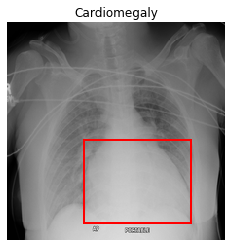

In [7]:
bidx = 167
raw_img = Image.open(os.path.join(img_path, bbN[bidx])).convert('RGB')
width, height = raw_img.size   # Get dimensions
x_scale = 256/width
y_scale = 256/height
raw_img = raw_img.resize((256, 256),Image.ANTIALIAS)
width, height = raw_img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
crop_del = (256-224)/2
raw_img = raw_img.crop((left, top, right, bottom)) 
raw_img= np.array(raw_img)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(raw_img)
x, y, w, h = int(bBox[bidx][0])*x_scale-crop_del, int(bBox[bidx][1])*y_scale-crop_del, int(bBox[bidx][2])*x_scale, int(bBox[bidx][3])*y_scale
rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes

img_label = np.array(CLASS_NAMES)[np.where(bbY[bidx]==1)[0]]
plt.title(img_label[0]) #show labels
plt.axis('off')

0.1364 -> Cardiomegaly
0.0794 -> Infiltration
0.0724 -> Effusion
0.0658 -> Edema
0.0658 -> Atelectasis
0.0656 -> Consolidation
0.0646 -> Pneumonia
0.0644 -> Nodule
0.0644 -> Pleural_Thickening
0.0643 -> Pneumothorax
0.0643 -> Mass
0.0642 -> Emphysema
0.0642 -> Fibrosis
0.0642 -> Hernia


(-0.5, 223.5, 223.5, -0.5)

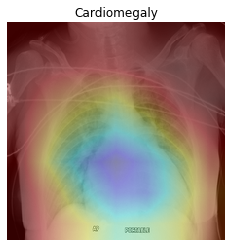

In [8]:
network_model = best_net.dense_net_121.features
network_model.eval()  # set network as evaluation model
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(bbI[bidx]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    var_output = network_model(input_img)#forword
    logit = best_net(input_img)#forword
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
        
cls_weights = list(best_net.parameters())
weight_softmax = np.squeeze(cls_weights[-2].data.cpu().numpy()) 
classes = {0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Effusion', 3: 'Infiltration', 4:'Mass', 5:'Nodule', 6:'Pneumonia',\
           7:'Pneumothorax',8:'Consolidation',9:'Edema',10:'Emphysema',11:'Fibrosis',12:'Pleural_Thickening',13:'Hernia'}
# output: the prediction
for i in range(0, N_CLASSES):
    line = '{:.4f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
    
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 224x224
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape

    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
    #cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, size_upsample)
    return cam_img
#get the class activation maps
cam_img = returnCAM(var_output.cpu().data.numpy(), weight_softmax, idx[0].item())
heat_map = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
plt.imshow(output_img)
plt.title(classes[idx[0].item()]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

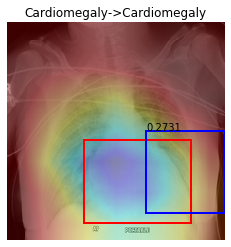

In [10]:
def IOU(xywh1, xywh2):#metric
    x1, y1, w1, h1 = xywh1
    x2, y2, w2, h2 = xywh2

    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    intersection = dx * dy if (dx >=0 and dy >= 0) else 0.
    
    union = w1 * h1 + w2 * h2 - intersection
    return (intersection / union)

# Find local maxima
data = cam_img
neighborhood_size = 100
threshold = .1

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
#for _ in range(5):
#    maxima = binary_dilation(maxima) 
labeled, num_objects = ndimage.label(maxima)
#slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(output_img)
rect = patches.Rectangle((x, y), w, h,linewidth=2, edgecolor='r', facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes
for pt in xy:
    if data[int(pt[0]), int(pt[1])] > np.max(data)*.9:
        x_p = int(max(pt[0], 0.))
        y_p = int(max(pt[1], 0.))
        w_p = int(min(x_p + w, 224)) - x_p
        h_p = int(min(y_p + h, 224)) - y_p
        
        IoU_score = IOU([x,y,w,h],[x_p,y_p,w_p,h_p])
        #print('IoU_score = {:.4f}'.format(IoU_score))
        rect = patches.Rectangle((x_p, y_p), w_p, h_p,linewidth=2, edgecolor='b', facecolor='none')# Create a Rectangle patch
        ax.add_patch(rect)# Add the patch to the Axes
        ax.text(x_p, y_p, '{:.4f}'.format(IoU_score))

plt.title(img_label[0] + '->' + classes[idx[0].item()]) #show labels
plt.axis('off')

In [80]:
#normal and abnormal 
nor_col = np.zeros(trY.shape[0])#add a column
trY_ex =  np.column_stack((trY, nor_col.T)) 
index = np.where(np.sum(trY, axis=1) == 0 )[0] #normal
trY_ex[index, -1] = 1 
print(trY_ex.shape)

nor_col = np.zeros(valY.shape[0])#add a column
valY_ex =  np.column_stack((valY, nor_col.T)) 
index = np.where(np.sum(valY, axis=1) == 0 )[0] #normal
valY_ex[index, -1] = 1 
print(valY_ex.shape)

nor_col = np.zeros(teY.shape[0])#add a column
teY_ex =  np.column_stack((teY, nor_col.T)) 
index = np.where(np.sum(teY, axis=1) == 0 )[0] #normal
teY_ex[index, -1] = 1 
print(teY_ex.shape)

CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', \
               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding'] 
N_CLASSES = len(CLASS_NAMES) #class numbers
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

(78468, 15)
(11219, 15)
(22433, 15)


In [78]:
#model training
N_CLASSES = len(CLASS_NAMES) #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
AUROC_best = 0.
batchSize = 32 #'Batch Size': 32
for epoch in range(30):#'Max Epoch': 50
    model.train()  # set network as train mode
    shuffled_idx = np.random.permutation(np.arange(len(trY_ex)))
    num_batches = len(shuffled_idx) // batchSize + 1
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(shuffled_idx), (i+1)*batchSize])
            selected_idx = shuffled_idx[min_idx:max_idx]
            I_batch = torch.from_numpy(trI[selected_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY_ex[selected_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch)#permute the dims of matrix， .permute(0, 3, 1, 2)
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY_ex) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY_ex), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch)#forword， .permute(0, 3, 1, 2)
            curr_loss = criterion(y_outputs, y_batch)
            gt = torch.cat((gt, y_batch), 0)
            pred = torch.cat((pred, y_outputs.data), 0)
            sys.stdout.write('\r {} / {} : validation loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    AUROCs = compute_AUCs(gt, pred)
    AUROC_avg =  AUROCs[14]#normal performance
    print("\r Eopch: %5d val_loss = %.6f avg_auroc= %.6f" % (epoch + 1, np.mean(loss_val), AUROC_avg)) 
    #if np.mean(loss_val) < best_loss:
    if AUROC_avg > AUROC_best:
        best_loss = np.mean(loss_val)
        AUROC_best = AUROC_avg
        best_net = copy.deepcopy(model)        
print("\r best_loss = %.6f best_auroc = %0.6f" % (best_loss, AUROC_best))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

 Eopch:     1 val_loss = 0.190999 avg_auroc= 0.743423
 Eopch:     2 val_loss = 0.188864 avg_auroc= 0.742577
 Eopch:     3 val_loss = 0.188148 avg_auroc= 0.754943
 Eopch:     4 val_loss = 0.183953 avg_auroc= 0.754989
 Eopch:     5 val_loss = 0.181965 avg_auroc= 0.755908
 Eopch:     6 val_loss = 0.182999 avg_auroc= 0.758699
 Eopch:     7 val_loss = 0.181388 avg_auroc= 0.763850
 Eopch:     8 val_loss = 0.179068 avg_auroc= 0.764859
 Eopch:     9 val_loss = 0.182035 avg_auroc= 0.761243
 Eopch:    10 val_loss = 0.180500 avg_auroc= 0.761611
 Eopch:    11 val_loss = 0.179766 avg_auroc= 0.764651
 Eopch:    12 val_loss = 0.179000 avg_auroc= 0.765654
 Eopch:    13 val_loss = 0.183622 avg_auroc= 0.760425
 Eopch:    14 val_loss = 0.179986 avg_auroc= 0.762694
 Eopch:    15 val_loss = 0.179397 avg_auroc= 0.763379
 Eopch:    16 val_loss = 0.180974 avg_auroc= 0.762123
 Eopch:    17 val_loss = 0.182492 avg_auroc= 0.761886
 Eopch:    18 val_loss = 0.180336 avg_auroc= 0.762707
 Eopch:    19 val_loss = 0.1

In [79]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY_ex) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 701 / 702 The average AUROC is 0.8122
The AUROC of Atelectasis is 0.7962
The AUROC of Cardiomegaly is 0.9039
The AUROC of Effusion is 0.8743
The AUROC of Infiltration is 0.6914
The AUROC of Mass is 0.8167
The AUROC of Nodule is 0.7350
The AUROC of Pneumonia is 0.7615
The AUROC of Pneumothorax is 0.8428
The AUROC of Consolidation is 0.7948
The AUROC of Edema is 0.8774
The AUROC of Emphysema is 0.8842
The AUROC of Fibrosis is 0.7943
The AUROC of Pleural_Thickening is 0.7504
The AUROC of Hernia is 0.8878
The AUROC of No Finding is 0.7722


In [29]:
def Image_Processing(img_path, crop_size=224):
    img = Image.open(img_path).convert('RGB').resize((256, 256),Image.ANTIALIAS) #open and resize
    #crop and normalize
    transform_sequence = transforms.Compose([
                                             #transforms.ToPILImage(), #if not PILImage
                                             transforms.CenterCrop(crop_size),
                                             #transforms.RandomCrop(crop_size),
                                             #transforms.RandomHorizontalFlip(),
                                             transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
                                             transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
    img = transform_sequence(img).numpy() #tensor to numpy
    return img
img_path = '/data/fjsdata/NIH-CXR/images/images/' 
#CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', \
#               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
CLASS_NAMES = ['Disease','No Finding'] 
idx = 7
#trainset statistics
#Atelectasis = 7996，Cardiomegaly = 1950,  Effusion =9261, Infiltration = 13914, Mass =3988, Nodule =4375, Pneumonia = 978,
#Pneumothorax = 3705, Consolidation =3263, Edema =1690, Emphysema =1799, Fibrosis =1158, Pleural_Thickening=2279, Hernia = 144,
#No Finding = 42405
trN, trI, trY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/train.txt', "r") as file_descriptor: #tarinset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = np.array([int(i) for i in image_label])  
            if np.sum(image_label) == 0: #normal
                trN.append(image_name)
                trY.append(np.array([0,1]))
                img = Image_Processing(os.path.join(img_path, image_name))
                trI.append(img)
            elif image_label[idx]==1: #every disease 
                trN.append(image_name)
                trY.append(np.array([1, 0]))
                img = Image_Processing(os.path.join(img_path, image_name))
                trI.append(img)
            else: continue               
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(trN),78468))
        sys.stdout.flush()
trI = np.array(trI)
trY = np.array(trY)   
print('The length of trainset is %d'%len(trN))
        
valN, valI, valY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/val.txt', "r") as file_descriptor: #valset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]          
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = np.array([int(i) for i in image_label])  
            if np.sum(image_label) == 0: #normal
                valN.append(image_name)
                valY.append(np.array([0,1]))
                img = Image_Processing(os.path.join(img_path, image_name))
                valI.append(img)
            elif image_label[idx]==1: #Infiltration
                valN.append(image_name)
                valY.append(np.array([1, 0]))
                img = Image_Processing(os.path.join(img_path, image_name))
                valI.append(img)
            else: continue 
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(valN), 11219))
        sys.stdout.flush()
valI = np.array(valI)
valY = np.array(valY) 
print('The length of validset is %d'%len(valN))

teN, teI, teY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/test.txt', "r") as file_descriptor: #testset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]      
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = np.array([int(i) for i in image_label])  
            if np.sum(image_label) == 0: #normal
                teN.append(image_name)
                teY.append(np.array([0,1]))
                img = Image_Processing(os.path.join(img_path, image_name))
                teI.append(img)
            elif image_label[idx]==1: #Infiltration
                teN.append(image_name)
                teY.append(np.array([1, 0]))
                img = Image_Processing(os.path.join(img_path, image_name))
                teI.append(img)
            else: continue 
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(teN),22433))
        sys.stdout.flush()
teI = np.array(teI)
teY = np.array(teY)    
print('The length of testset is %d'%len(teN))

46110 / 78468 The length of trainset is 46110
6583 / 11219 The length of validset is 6583
13017 / 22433 The length of testset is 13017


In [ ]:
N_CLASSES = len(CLASS_NAMES) #class numbers
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

#model training
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
AUROC_best = 0.
batchSize = 32 #'Batch Size': 32
for epoch in range(10):#'Max Epoch': 50
    model.train()  # set network as train mode
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    num_batches = len(shuffled_idx) // batchSize + 1
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(shuffled_idx), (i+1)*batchSize])
            selected_idx = shuffled_idx[min_idx:max_idx]
            I_batch = torch.from_numpy(trI[selected_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY[selected_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch)#permute the dims of matrix， .permute(0, 3, 1, 2)
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch)#forword， .permute(0, 3, 1, 2)
            curr_loss = criterion(y_outputs, y_batch)
            gt = torch.cat((gt, y_batch), 0)
            pred = torch.cat((pred, y_outputs.data), 0)
            sys.stdout.write('\r {} / {} : validation loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    AUROCs = compute_AUCs(gt, pred)
    AUROC_avg = np.array(AUROCs).mean()
    print("\r Eopch: %5d val_loss = %.6f avg_auroc= %.6f" % (epoch + 1, np.mean(loss_val), AUROC_avg)) 
    #if np.mean(loss_val) < best_loss:
    if AUROC_avg > AUROC_best:
        best_loss = np.mean(loss_val)
        AUROC_best = AUROC_avg
        best_net = copy.deepcopy(model)        
print("\r best_loss = %.6f best_auroc = %0.6f" % (best_loss, AUROC_best))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

 Eopch:     1 val_loss = 0.217640 avg_auroc= 0.825821
 Eopch:     2 val_loss = 0.237675 avg_auroc= 0.822070
 Eopch:     3 val_loss = 0.208509 avg_auroc= 0.844603
 Eopch:     4 val_loss = 0.212765 avg_auroc= 0.835633
 Eopch:     5 val_loss = 0.196199 avg_auroc= 0.873044
 Eopch:     6 val_loss = 0.199448 avg_auroc= 0.865309
 1307 / 1441 : train loss = 0.061847

In [28]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 380 / 381 The average AUROC is 0.7415
The AUROC of Disease is 0.7413
The AUROC of No Finding is 0.7417


In [101]:
#normal and abnormal 
nor_col = np.zeros(trY.shape[0])#add a column
trY_ex =  np.column_stack((trY, nor_col.T)) 
index = np.where(np.sum(trY, axis=1) == 0 )[0] #normal
trY_ex[index, -1] = 1 
print(trY_ex.shape)

nor_col = np.zeros(valY.shape[0])#add a column
valY_ex =  np.column_stack((valY, nor_col.T)) 
index = np.where(np.sum(valY, axis=1) == 0 )[0] #normal
valY_ex[index, -1] = 1 
print(valY_ex.shape)

nor_col = np.zeros(teY.shape[0])#add a column
teY_ex =  np.column_stack((teY, nor_col.T)) 
index = np.where(np.sum(teY, axis=1) == 0 )[0] #normal
teY_ex[index, -1] = 1 
print(teY_ex.shape)

(78468, 15)
(11219, 15)
(22433, 15)


In [ ]:
#Atelectasis = 7996，Cardiomegaly = 1950,  Effusion =9261, Infiltration = 13914, Mass =3988, Nodule =4375, Pneumonia = 978,
#Pneumothorax = 3705, Consolidation =3263, Edema =1690, Emphysema =1799, Fibrosis =1158, Pleural_Thickening=2279, Hernia = 144,
#No Finding = 42405

#normal and Infiltration 
idx = np.append(np.where(trY_ex[:,3]==1)[0], np.where(trY_ex[:,14]==1)[0])
trY_ex = trY_ex[idx]
trI_ex = trI[idx]
print(trY_ex.shape)
print(trI_ex.shape)

#CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', \
#               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding'] 
CLASS_NAMES = ['Infiltration','No Finding'] 
N_CLASSES = len(CLASS_NAMES) #class numbers
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs